In [124]:
cam0 = '/home/azhuravl/nobackup/iphone/paper-windmill/camera/0_00100.json'
cam1 = '/home/azhuravl/nobackup/iphone/paper-windmill/camera/1_00100.json'
cam2 = '/home/azhuravl/nobackup/iphone/paper-windmill/camera/2_00100.json' 

depth0 = '/home/azhuravl/nobackup/iphone/paper-windmill/depth/1x/0_00100.npy'
rgb0 = '/home/azhuravl/nobackup/iphone/paper-windmill/rgb/1x/0_00100.png'

# read everything
import json
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt

with open(cam0, 'r') as f:
    cam_0 = json.load(f)
with open(cam1, 'r') as f:
    cam_1 = json.load(f)
with open(cam2, 'r') as f:
    cam_2 = json.load(f)
depth_0 = np.load(depth0)[:, :, 0]
rgb_0 = iio.imread(rgb0)

In [125]:
import json
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt
import viser

def parse_iphone_camera(cam_data):
    """Parse iPhone camera format to standard format"""
    # Extract parameters
    focal_length = cam_data['focal_length']
    image_size = cam_data['image_size']  # [width, height]
    position = np.array(cam_data['position'])
    orientation = np.array(cam_data['orientation'])
    principal_point = cam_data['principal_point']
    
    # Create intrinsic matrix K
    K = np.array([
        [focal_length, 0, principal_point[0]],
        [0, focal_length, principal_point[1]], 
        [0, 0, 1]
    ])
    
    # Convert to camera-to-world (c2w) format
    R = np.array(orientation)  # 3x3 rotation matrix
    t = np.array(position)     # 3D position
    
    # Create c2w matrix
    c2w = np.eye(4)
    c2w[:3, :3] = R.T  # Transpose for c2w
    c2w[:3, 3] = -R.T @ t  # Apply inverse transformation
    
    c2w = np.linalg.inv(c2w)  # Invert to get c2w
    
    return K, c2w, image_size

def create_colored_point_cloud(depth, rgb, K, c2w, subsample=8):
    """Create colored point cloud from depth and RGB"""
    # Handle depth shape: (960, 720, 1) -> (960, 720)
    if len(depth.shape) == 3:
        depth = depth.squeeze(-1)  # Remove last dimension
    
    # Handle RGB shape: (960, 720, 4) -> (960, 720, 3) (remove alpha)
    if rgb.shape[-1] == 4:
        rgb = rgb[:, :, :3]  # Take only RGB channels
    
    H, W = depth.shape
    print(f"Processing depth shape: {depth.shape}, RGB shape: {rgb.shape}")
    
    # Create pixel coordinates (subsample for performance)
    v, u = np.meshgrid(np.arange(0, H, subsample), np.arange(0, W, subsample), indexing='ij')
    u = u.flatten()
    v = v.flatten()
    
    # Get depth and RGB values at subsampled locations
    depth_vals = depth[::subsample, ::subsample].flatten()
    rgb_vals = rgb[::subsample, ::subsample].reshape(-1, 3)
    
    # Filter out invalid depths
    valid = (depth_vals > 0) & (depth_vals < 50)  # Adjust max depth as needed
    u, v, depth_vals, rgb_vals = u[valid], v[valid], depth_vals[valid], rgb_vals[valid]
    
    print(f"Valid points: {len(depth_vals)} out of {len(depth[::subsample, ::subsample].flatten())}")
    
    # Ensure RGB is in [0,255] range
    if rgb_vals.max() <= 1.0:
        rgb_vals = (rgb_vals * 255).astype(np.uint8)
    else:
        rgb_vals = rgb_vals.astype(np.uint8)
    
    # Back-project to 3D camera coordinates
    x_cam = (u - K[0, 2]) * depth_vals / K[0, 0]
    y_cam = (v - K[1, 2]) * depth_vals / K[1, 1]
    z_cam = depth_vals
    
    # Transform to world coordinates
    points_cam = np.stack([x_cam, y_cam, z_cam, np.ones_like(x_cam)])
    points_world = c2w @ points_cam
    
    return points_world[:3].T, rgb_vals

# Start Viser server (stop existing one if running)
try:
    if 'server' in globals():
        server.stop()
except:
    pass

server = viser.ViserServer(port=8083)
print("iPhone visualization at http://localhost:8083")

# Clear scene
server.scene.reset()

# Use the loaded data (assuming depth_0 and rgb_0 are already loaded)
# Fix variable name: depth_0 instead of depth
depth_data = depth_0  # (960, 720, 1)
rgb_data = rgb_0      # (960, 720, 4)

print(f"Original depth shape: {depth_data.shape}")
print(f"Original RGB shape: {rgb_data.shape}")
print(f"Depth range: [{depth_data.min():.3f}, {depth_data.max():.3f}]")
print(f"RGB range: [{rgb_data.min()}, {rgb_data.max()}]")

# Load and process cameras
cameras = [cam_0, cam_1, cam_2]
camera_names = ['Camera 0', 'Camera 1', 'Camera 2'] 
camera_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # Red, Green, Blue

print("\n=== CAMERA PARAMETERS ===")
for i, (cam_data, name, color) in enumerate(zip(cameras, camera_names, camera_colors)):
    K, c2w, image_size = parse_iphone_camera(cam_data)
    
    print(f"\n{name}:")
    print(f"  Position: {c2w[:3, 3]}")
    print(f"  Image size: {image_size} (W x H)")
    print(f"  Focal length: {cam_data['focal_length']}")
    
    # Add camera frustum
    server.scene.add_camera_frustum(
        name=f"camera_{i}",
        fov=60,  # Approximate
        aspect=image_size[0] / image_size[1],  # width/height
        scale=0.1,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        color=color
    )

# Create point cloud from Camera 0
print("\n=== CREATING POINT CLOUD ===")
K_0, c2w_0, image_size_0 = parse_iphone_camera(cam_0)

# Create colored point cloud
points_3d, colors = create_colored_point_cloud(
    depth_data, rgb_data, K_0, c2w_0, subsample=8
)

print(f"Generated {len(points_3d)} 3D points")
if len(points_3d) > 0:
    print(f"Point cloud bounds:")
    print(f"  X: [{points_3d[:, 0].min():.3f}, {points_3d[:, 0].max():.3f}]")
    print(f"  Y: [{points_3d[:, 1].min():.3f}, {points_3d[:, 1].max():.3f}]")
    print(f"  Z: [{points_3d[:, 2].min():.3f}, {points_3d[:, 2].max():.3f}]")

    # Add point cloud
    server.scene.add_point_cloud(
        name="camera0_pointcloud",
        points=points_3d,
        colors=colors,
        point_size=0.01
    )
else:
    print("⚠️  No valid points generated - check depth values and range")

# Add coordinate frame
server.scene.add_frame(
    name="/world_origin", 
    axes_length=0.2, 
    position=(0, 0, 0)
)

print("\n✓ Visualization complete!")
print("🔴 Red = Camera 0 (with point cloud)")
print("🟢 Green = Camera 1") 
print("🔵 Blue = Camera 2")
print("Check http://localhost:8083 in your browser")

(viser) Connection closed (0, 0 total)

(viser) Server stopped

╭──────────────── viser ────────────────╮
│             ╷                         │
│   HTTP      │ http://localhost:8083   │
│   Websocket │ ws://localhost:8083     │
│             ╵                         │
╰───────────────────────────────────────╯

iPhone visualization at http://localhost:8083
Original depth shape: (960, 720)
Original RGB shape: (960, 720, 4)
Depth range: [0.000, 1.162]
RGB range: [0, 255]

=== CAMERA PARAMETERS ===

Camera 0:
  Position: [ 0.35529384  0.02633714 -0.11243132]
  Image size: [720, 960] (W x H)
  Focal length: 719.9471435546875

Camera 1:
  Position: [ 0.61324698  0.02343152 -0.19585609]
  Image size: [720, 960] (W x H)
  Focal length: 728.0621948242188

Camera 2:
  Position: [ 0.11971193 -0.0510009   0.08332626]
  Image size: [720, 960] (W x H)
  Focal length: 724.8651733398438

=== CREATING POINT CLOUD ===
Processing depth shape: (960, 720), RGB shape: (960, 720, 3)
Valid points: 9758 out of 10800
Generated 9758 3D points
Point cloud bounds:
  X: [-0.707, 0.282]
  Y: [-0.589, 0.497]
  Z: [-1.209, -0.481]

✓ Visualization complete!
🔴 Red = Camera 0 (with point cloud)
🟢 Green = Camera 1
🔵 Blue = Camera 2
Check http://localhost:8083 in your browser


In [ ]:
def project_points_to_camera(points_3d, colors_3d, K, c2w, image_size):
    """Project 3D points to a camera's image plane"""
    # Convert c2w to w2c (world-to-camera)
    w2c = np.linalg.inv(c2w)
    
    # Transform points to camera coordinates
    points_homo = np.hstack([points_3d, np.ones((len(points_3d), 1))])  # Make homogeneous
    points_cam = (w2c @ points_homo.T).T  # [N, 4] -> [4, N] -> [N, 4]
    
    # Only keep points in front of camera (positive Z)
    valid_z = points_cam[:, 2] > 0
    points_cam = points_cam[valid_z]
    colors_proj = colors_3d[valid_z]
    
    if len(points_cam) == 0:
        return np.zeros(image_size[::-1] + (3,), dtype=np.uint8), 0
    
    # Project to image plane
    points_2d = K @ points_cam[:, :3].T  # [3, 3] @ [3, N] -> [3, N]
    points_2d = points_2d.T  # [N, 3]
    
    # Convert to pixel coordinates
    pixels = points_2d[:, :2] / points_2d[:, 2:]  # Divide by Z
    u = pixels[:, 0].astype(int)
    v = pixels[:, 1].astype(int)
    
    # Filter points within image bounds
    W, H = image_size  # width, height
    valid_pixels = (u >= 0) & (u < W) & (v >= 0) & (v < H)
    
    u = u[valid_pixels]
    v = v[valid_pixels]
    colors_final = colors_proj[valid_pixels]
    
    # Create rendered image
    rendered = np.zeros((H, W, 3), dtype=np.uint8)
    if len(u) > 0:
        rendered[v, u] = colors_final
    
    return rendered, len(u)

# Project point cloud to cameras 1 and 2
print("=== RENDERING CAMERA VIEWS ===")

K_1, c2w_1, image_size_1 = parse_iphone_camera(cam_1)
K_2, c2w_2, image_size_2 = parse_iphone_camera(cam_2)

# Render what camera 1 sees
rendered_1, num_points_1 = project_points_to_camera(points_3d, colors, K_1, c2w_1, image_size_1)
print(f"Camera 1: Rendered {num_points_1} points")

# Render what camera 2 sees  
rendered_2, num_points_2 = project_points_to_camera(points_3d, colors, K_2, c2w_2, image_size_2)
print(f"Camera 2: Rendered {num_points_2} points")

# Add rendered views as image planes in Viser
print("Adding rendered views to Viser...")

# Add camera 1 rendered view
server.scene.add_image(
    name="camera1_view",
    image=rendered_1,
    render_width=0.3,
    render_height=0.4,
    position=c2w_1[:3, 3] + c2w_1[:3, 2] * 0.15,  # Offset along camera's forward direction
    wxyz=viser.transforms.SO3.from_matrix(c2w_1[:3, :3]).wxyz,
)

# Add camera 2 rendered view
server.scene.add_image(
    name="camera2_view", 
    image=rendered_2,
    render_width=0.3,
    render_height=0.4,
    position=c2w_2[:3, 3] + c2w_2[:3, 2] * 0.15,  # Offset along camera's forward direction
    wxyz=viser.transforms.SO3.from_matrix(c2w_2[:3, :3]).wxyz,
)

print("✓ Rendered views added to Viser!")
print("🟢 Green camera now has its rendered view")
print("🔵 Blue camera now has its rendered view")

=== RENDERING CAMERA VIEWS ===
Camera 1: Rendered 9050 points
Camera 2: Rendered 7516 points
Adding rendered views to Viser...
✓ Rendered views added to Viser!
🟢 Green camera now has its rendered view
🔵 Blue camera now has its rendered view


(viser) Connection opened (0, 1 total), 29 persistent messages

In [ ]:
iphone/paper-windmill/camera/0_00100.json
iphone/paper-windmill/depth/1x/0_00100.npy
iphone/paper-windmill/depth/2x/0_00100.npy
iphone/paper-windmill/rgb/1x/0_00100.png
iphone/paper-windmill/rgb/2x/0_00100.png


In [108]:
import os
import json
import numpy as np
import imageio.v3 as iio
import torch
from torch.utils.data import Dataset
from pathlib import Path

class iPhoneDataset(Dataset):
    """
    Dataset class for iPhone multi-view data
    
    Structure:
    iphone/{sequence}/camera/{camera_id}_{frame_id:05d}.json
    iphone/{sequence}/depth/{scale}x/{camera_id}_{frame_id:05d}.npy  (only camera 0)
    iphone/{sequence}/rgb/{scale}x/{camera_id}_{frame_id:05d}.png
    """
    
    def __init__(self, 
                 root_dir,
                 sequence_name,
                 scale='1x',
                 camera_ids=[0, 1, 2],
                 frame_range=None,
                 load_depth=True,
                 load_rgb=True,
                 min_sequence_length=49):
        """
        Args:
            root_dir: Path to 'iphone' directory
            sequence_name: Name of sequence (e.g., 'paper-windmill')
            scale: Image scale ('1x' or '2x')
            camera_ids: List of camera IDs to load [0, 1, 2]
            frame_range: Tuple (start, end) or None for all frames
            load_depth: Whether to load depth data (only available for camera 0)
            load_rgb: Whether to load RGB data
            min_sequence_length: Minimum length of contiguous sequences to keep
        """
        self.root_dir = Path(root_dir)
        self.sequence_name = sequence_name
        self.scale = scale
        self.camera_ids = camera_ids
        self.load_depth = load_depth
        self.load_rgb = load_rgb
        self.min_sequence_length = min_sequence_length
        
        # Build paths
        self.sequence_dir = self.root_dir / sequence_name
        self.camera_dir = self.sequence_dir / 'camera'
        self.depth_dir = self.sequence_dir / 'depth' / scale
        self.rgb_dir = self.sequence_dir / 'rgb' / scale
        
        # Discover available frames
        self.frame_ids, self.contiguous_sequences = self._discover_frames(frame_range)
        
        if len(self.frame_ids) == 0:
            raise ValueError(f"No contiguous sequences of length >= {min_sequence_length} found!")
        
        print(f"iPhoneDataset initialized:")
        print(f"  Sequence: {sequence_name}")
        print(f"  Scale: {scale}")
        print(f"  Cameras: {camera_ids}")
        print(f"  Depth only available for camera 0")
        print(f"  Total valid frames: {len(self.frame_ids)} ({min(self.frame_ids):05d}-{max(self.frame_ids):05d})")
        print(f"  Contiguous sequences: {len(self.contiguous_sequences)}")
        
    def _discover_frames(self, frame_range):
        """Discover contiguous sequences where all cameras have data"""
        
        # First, collect all available frame IDs for each camera
        camera_frames = {}
        
        for cam_id in self.camera_ids:
            camera_files = list(self.camera_dir.glob(f"{cam_id}_*.json"))
            cam_frame_ids = set()
            
            for file_path in camera_files:
                frame_id = int(file_path.stem.split('_')[1])
                
                # Check if all required files exist for this camera and frame
                files_exist = True
                
                # Check camera file (already know it exists from glob)
                
                # Check depth file only for camera 0
                if self.load_depth and cam_id == 0:
                    depth_file = self.depth_dir / f"{cam_id}_{frame_id:05d}.npy"
                    if not depth_file.exists():
                        files_exist = False
                
                # Check RGB file (required for all cameras)
                if self.load_rgb:
                    rgb_file = self.rgb_dir / f"{cam_id}_{frame_id:05d}.png"
                    if not rgb_file.exists():
                        files_exist = False
                
                if files_exist:
                    cam_frame_ids.add(frame_id)
            
            camera_frames[cam_id] = sorted(list(cam_frame_ids))
            print(f"Camera {cam_id}: {len(cam_frame_ids)} frames available ({min(cam_frame_ids) if cam_frame_ids else 'N/A'}-{max(cam_frame_ids) if cam_frame_ids else 'N/A'})")
        
        # Find intersection - frames where ALL cameras have data
        common_frames = set(camera_frames[self.camera_ids[0]])
        for cam_id in self.camera_ids[1:]:
            common_frames = common_frames.intersection(set(camera_frames[cam_id]))
        
        common_frames = sorted(list(common_frames))
        print(f"Common frames across all cameras: {len(common_frames)}")
        
        if len(common_frames) == 0:
            return [], []
        
        # Apply frame range filter if specified
        if frame_range is not None:
            start, end = frame_range
            common_frames = [f for f in common_frames if start <= f <= end]
            print(f"After frame range filter [{start}-{end}]: {len(common_frames)} frames")
        
        # Find contiguous sequences of at least min_sequence_length
        contiguous_sequences = []
        current_sequence = []
        
        for i, frame_id in enumerate(common_frames):
            if i == 0 or frame_id == common_frames[i-1] + 1:
                # Continue current sequence
                current_sequence.append(frame_id)
            else:
                # Gap found, save current sequence if long enough
                if len(current_sequence) >= self.min_sequence_length:
                    contiguous_sequences.append(current_sequence)
                current_sequence = [frame_id]
        
        # Don't forget the last sequence
        if len(current_sequence) >= self.min_sequence_length:
            contiguous_sequences.append(current_sequence)
        
        print(f"Found {len(contiguous_sequences)} contiguous sequences of length >= {self.min_sequence_length}")
        for i, seq in enumerate(contiguous_sequences):
            print(f"  Sequence {i}: frames {seq[0]}-{seq[-1]} (length {len(seq)})")
        
        # Return all frames from valid sequences
        all_valid_frames = []
        for seq in contiguous_sequences:
            all_valid_frames.extend(seq)
        
        return sorted(all_valid_frames), contiguous_sequences
    
    def __len__(self):
        return len(self.frame_ids)
    
    def __getitem__(self, idx):
        """
        Returns:
            dict with keys:
            - 'frame_id': int
            - 'cameras': dict with camera_id -> camera_data
            where camera_data contains:
                - 'camera_params': parsed camera parameters
                - 'K': intrinsic matrix [3, 3]
                - 'c2w': camera-to-world matrix [4, 4] 
                - 'depth': depth map [H, W] or None (only for camera 0)
                - 'rgb': RGB image [H, W, 3] (if load_rgb=True)
        """
        frame_id = self.frame_ids[idx]
        
        data = {
            'frame_id': frame_id,
            'cameras': {}
        }
        
        for cam_id in self.camera_ids:
            camera_data = self._load_camera_data(cam_id, frame_id)
            data['cameras'][cam_id] = camera_data
            
        return data
    
    def _load_camera_data(self, camera_id, frame_id):
        """Load all data for a specific camera and frame"""
        camera_data = {}
        
        # Load camera parameters
        camera_file = self.camera_dir / f"{camera_id}_{frame_id:05d}.json"
        with open(camera_file, 'r') as f:
            camera_params = json.load(f)
        
        camera_data['camera_params'] = camera_params
        
        # Parse camera parameters
        K, c2w = self._parse_camera_params(camera_params)
        camera_data['K'] = K
        camera_data['c2w'] = c2w
        
        # Load depth if requested and available (only for camera 0)
        if self.load_depth:
            if camera_id == 0:
                depth_file = self.depth_dir / f"{camera_id}_{frame_id:05d}.npy"
                if depth_file.exists():
                    depth = np.load(depth_file)
                    if len(depth.shape) == 3:
                        depth = depth.squeeze(-1)  # Remove singleton dimension
                    camera_data['depth'] = depth
                else:
                    camera_data['depth'] = None
                    print(f"Warning: Depth file not found for camera {camera_id}, frame {frame_id:05d}")
            else:
                # Depth not available for other cameras
                camera_data['depth'] = None
            
        # Load RGB if requested
        if self.load_rgb:
            rgb_file = self.rgb_dir / f"{camera_id}_{frame_id:05d}.png"
            if rgb_file.exists():
                rgb = iio.imread(rgb_file)
                if rgb.shape[-1] == 4:  # Remove alpha channel
                    rgb = rgb[:, :, :3]
                camera_data['rgb'] = rgb
            else:
                raise FileNotFoundError(f"RGB file not found: {rgb_file}")
            
        return camera_data
    
    def _parse_camera_params(self, camera_params):
        """Parse iPhone camera format to K and c2w matrices"""
        # Extract parameters
        focal_length = camera_params['focal_length']
        principal_point = camera_params['principal_point']
        position = np.array(camera_params['position'])
        orientation = np.array(camera_params['orientation'])
        
        # Create intrinsic matrix K
        K = np.array([
            [focal_length, 0, principal_point[0]],
            [0, focal_length, principal_point[1]], 
            [0, 0, 1]
        ], dtype=np.float32)
        
        # Create camera-to-world matrix
        R = orientation  # 3x3 rotation matrix
        t = position     # 3D position
        
        c2w = np.eye(4, dtype=np.float32)
        c2w[:3, :3] = R.T  # Transpose for c2w
        c2w[:3, 3] = -R.T @ t  # Apply inverse transformation
        
        return K, c2w
    
    def get_camera_info(self, camera_id, frame_id):
        """Get camera info for specific camera and frame"""
        idx = self.frame_ids.index(frame_id)
        data = self[idx]
        return data['cameras'][camera_id]
    
    def get_frame_by_id(self, frame_id):
        """Get data for specific frame ID"""
        idx = self.frame_ids.index(frame_id)
        return self[idx]
    
    def get_contiguous_subsequences(self, sequence_length):
        """Get all contiguous subsequences of specified length"""
        subsequences = []
        
        for seq in self.contiguous_sequences:
            if len(seq) >= sequence_length:
                for start_idx in range(len(seq) - sequence_length + 1):
                    subseq = seq[start_idx:start_idx + sequence_length]
                    subsequences.append(subseq)
        
        print(f"Generated {len(subsequences)} subsequences of length {sequence_length}")
        return subsequences
    
    def get_sequence_data(self, frame_ids):
        """Get data for a specific sequence of frame IDs"""
        sequence_data = []
        for frame_id in frame_ids:
            idx = self.frame_ids.index(frame_id)
            sequence_data.append(self[idx])
        return sequence_data
    
    def get_random_sequence(self, sequence_length):
        """Get a random contiguous sequence of specified length"""
        valid_sequences = []
        for seq in self.contiguous_sequences:
            if len(seq) >= sequence_length:
                valid_sequences.append(seq)
        
        if not valid_sequences:
            raise ValueError(f"No sequences of length >= {sequence_length} available")
        
        # Pick random sequence and random starting point
        chosen_seq = np.random.choice(valid_sequences)
        max_start = len(chosen_seq) - sequence_length
        start_idx = np.random.randint(0, max_start + 1)
        
        selected_frames = chosen_seq[start_idx:start_idx + sequence_length]
        return self.get_sequence_data(selected_frames)
    
    def has_depth(self, camera_id):
        """Check if depth data is available for given camera"""
        return camera_id == 0 and self.load_depth


In [110]:
# Example 1: Load dataset
# dataset = iPhoneDataset(
#     root_dir='/home/azhuravl/nobackup/iphone',
#     sequence_name='paper-windmill',
#     scale='1x',
#     camera_ids=[0, 1, 2],
#     min_sequence_length=49
# )

# print(f"\nDataset size: {len(dataset)}")

# # Example 2: Check depth availability
# for cam_id in dataset.camera_ids:
#     print(f"Camera {cam_id} has depth: {dataset.has_depth(cam_id)}")

# # Example 3: Examine first sample
# if len(dataset) > 0:
#     sample = dataset[0]
#     print(f"\nFirst sample - Frame ID: {sample['frame_id']}")
#     for cam_id, cam_data in sample['cameras'].items():
#         print(f"  Camera {cam_id}:")
#         print(f"    RGB shape: {cam_data['rgb'].shape}")
#         depth_info = f"    Depth: {cam_data['depth'].shape}" if cam_data['depth'] is not None else "    Depth: None"
#         print(depth_info)
#         print(f"    Position: {cam_data['c2w'][:3, 3]}")

# Example 4: Get sequence with mixed depth availability
subsequences = dataset.get_contiguous_subsequences(10)
if len(subsequences) > 0:
    seq_data = dataset.get_sequence_data(subsequences[0])
    print(f"\nSequence example:")
    print(f"Frames: {[d['frame_id'] for d in seq_data]}")
    
    # Check depth availability across cameras
    for frame_data in seq_data[:2]:  # Just first 2 frames
        frame_id = frame_data['frame_id']
        print(f"Frame {frame_id}:")
        for cam_id in dataset.camera_ids:
            has_depth = frame_data['cameras'][cam_id]['depth'] is not None
            print(f"  Camera {cam_id}: depth={'✓' if has_depth else '✗'}")

Generated 124 subsequences of length 10

Sequence example:
Frames: [77, 78, 79, 80, 81, 82, 83, 84, 85, 86]
Frame 77:
  Camera 0: depth=✓
  Camera 1: depth=✗
  Camera 2: depth=✗
Frame 78:
  Camera 0: depth=✓
  Camera 1: depth=✗
  Camera 2: depth=✗


In [112]:
seq_data = dataset.get_sequence_data(subsequences[0])

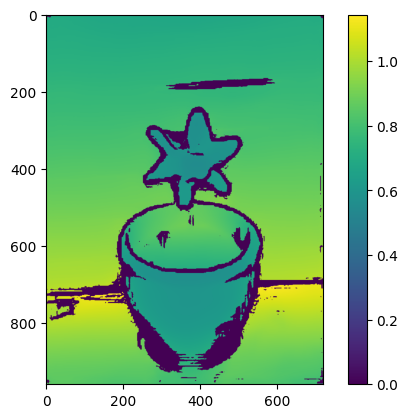

In [120]:
# plot seq_data[0]['cameras'][0]['depth']

plt.imshow(seq_data[0]['cameras'][0]['depth'])
plt.colorbar()
